In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
from vit import ViT
from cbvit import CBViT
from appmatcher import APP_MATCHER
from testcbvit import test_cbvit

device = torch.device("cuda:7")

test_transform = torchvision.transforms.ToTensor()

#for ViT
train_cls_dataset = torchvision.datasets.MNIST(root="../data", download=True, train=True, transform=test_transform)
test_cls_dataset = torchvision.datasets.MNIST(root="../data", download=True, train=False, transform=test_transform)
train_cls_loader = torch.utils.data.DataLoader(train_cls_dataset, batch_size=128, num_workers=8, shuffle=True)
test_cls_loader = torch.utils.data.DataLoader(test_cls_dataset, batch_size=1000, num_workers=8, shuffle=False)

#for CBViT
train_dataset = APP_MATCHER('../data', train=True, download=True)
test_dataset = APP_MATCHER('../data', train=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, num_workers=8, shuffle=False)

TrainCBViT = False
TrainViT = False


In [2]:
#CBViT
cbvit = CBViT().to(device)

if TrainCBViT == True:
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(cbvit.parameters(), lr=1e-3)#, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
    best_acc = 0
    for epoch in range(1, 500+1):
        print ("Epoch {}:".format(epoch))
        cbvit.train()
        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            inputs = torch.cat([img1, img2], axis=1)
            optimizer.zero_grad()
            outputs, _ = cbvit(inputs)
            outputs = outputs[:,0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        print('Training loss: {}'.format(loss.item()))

        if epoch % 20 == 0:
            for param_group in optimizer.param_groups:
                lr_print = (param_group['lr'])
                break
            print('lr: {}'.format(lr_print))
            
            #different k
            test_acc1 = test_cbvit(cbvit, device, test_cls_loader, 5, 10)
            test_acc2 = test_cbvit(cbvit, device, test_cls_loader, 15, 15)
            test_acc3 = test_cbvit(cbvit, device, test_cls_loader, 25, 25)
            
            #if test_acc > best_acc:
            if max(test_acc1,test_acc2,test_acc3) > best_acc:
                #best_acc = test_acc
                best_acc = max(test_acc1,test_acc2,test_acc3)
                torch.save(cbvit.state_dict(), "CBViT.pt")
                
            #print ("acc{}:, best_acc:{}".format(test_acc, best_acc))
            print (test_acc1)
            print (test_acc2)
            print (test_acc3)
            print ("acc{}:, best_acc:{}".format(max(test_acc1,test_acc2,test_acc3), best_acc))
            
else:
    cbvit.load_state_dict(torch.load("CBViT.pt"))
    cbvit.eval()

In [3]:
#ViT
vit = ViT(pool='mean', image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=8, mlp_dim=128).to(device)

if TrainViT == True:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(vit.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
    best_acc = 0
    
    for epoch in range(1, 500+1):
        print ("Epoch {}:".format(epoch))
        for img, targets in train_cls_loader:
            img, targets = img.to(device), targets.to(device)
            vit.train()
            optimizer.zero_grad()
            output = vit(img)[0]
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

        print('Training loss: {}'.format(loss.item()))
        if epoch % 20 == 0:
            vit.eval()
            correct = 0
            count = 0
                
            for img, targets in test_cls_loader:
                img, targets = img.to(device), targets.to(device)
                with torch.no_grad():
                    output = vit(img)[0]
                predictions = torch.argmax(output, axis=1)
                correct += torch.sum(predictions==targets)
                count += targets.size(0)

            test_acc = correct/count
                    
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(vit.state_dict(), "ViT.pt")
                
            print ("acc{}:, best_acc:{}".format(test_acc, best_acc))

else:
    #vit.load_state_dict(torch.load("cls_vit.pth"))
    vit.load_state_dict(torch.load("ViT.pt"))
    vit.eval()

In [4]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

train_X = []
train_y = []
test_X = []
test_y = []
for data, label in train_cls_dataset:
    train_X.append(data.view(784).numpy())
    train_y.append(label)
    
for data, label in test_cls_dataset:
    test_X.append(data.view(784).numpy())
    test_y.append(label)
    
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

for k in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X, train_y)
    prediction = knn.predict(test_X)
    print (k,sum(prediction == test_y))

2 9627
3 9705
4 9682
5 9688
6 9677
7 9694
8 9670
9 9659
10 9665
11 9668
12 9661
13 9653
14 9640


In [5]:
#Randomly select some images for visualization
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_cls_loader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1][0])
    if min(len(d) for d in digits) >= 100:
        break;


In [6]:
#Load prototypes (Average digits)
from torchvision import transforms
from PIL import Image
#prototypes are generated using our prior work C2C-VAE
prototypes = []
for i in range(10):
    prototype = Image.open("prototypes/"+str(i)+".png").convert('L')
    prototype = transforms.ToTensor()(np.array(prototype))
    prototypes.append(prototype)

(-0.5, 27.5, 27.5, -0.5)

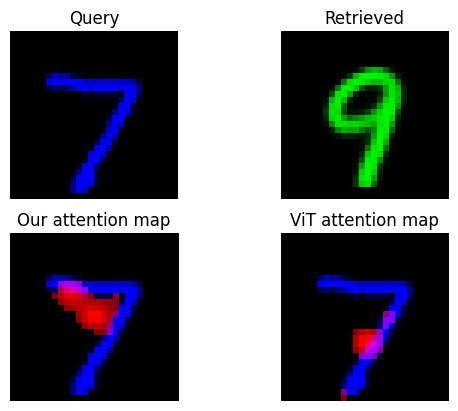

In [7]:
img1 = digits[7][0].to(device)
img2 = prototypes[9].to(device) #Use prototype as reference

normalized_img1 = img1
normalized_img2 = img2
sharpen = True

with torch.no_grad():
    _, vit_attn = vit(normalized_img1.unsqueeze(0))
    
vit_attn = torch.stack(vit_attn)
vit_attn = torch.mean(vit_attn, axis=0)
vit_attn = torch.mean(vit_attn, axis=0)
vit_attn = torch.mean(vit_attn, axis=0)
vit_attn = vit_attn[0,1:].view([7,7])
vit_attn = torchvision.transforms.Resize([28,28])(vit_attn.unsqueeze(0))[0]
#rescale to 0 and 1, then sharpen
vit_min = vit_attn.min()
vit_max = vit_attn.max()
vit_attn = (vit_attn - vit_min) / (vit_max - vit_min)
if sharpen:
    vit_attn[vit_attn<0.5] = 0.0

with torch.no_grad():
    _, cbvit_attn = cbvit(torch.cat([normalized_img1,normalized_img2],axis=0).unsqueeze(0))
    
cbvit_attn = torch.stack(cbvit_attn)
cbvit_attn = torch.mean(cbvit_attn, axis=0)
cbvit_attn = torch.mean(cbvit_attn, axis=0)
cbvit_attn = torch.mean(cbvit_attn, axis=0)
cbvit_attn = cbvit_attn[0,1:].view([7,7])
cbvit_attn = torchvision.transforms.Resize([28,28])(cbvit_attn.unsqueeze(0))[0]
cbvit_min = cbvit_attn.min()
cbvit_max = cbvit_attn.max()
cbvit_attn = (cbvit_attn - cbvit_min) / (cbvit_max - cbvit_min)
if sharpen:
    cbvit_attn[cbvit_attn<0.5] = 0.0

query = torch.stack([torch.zeros([28,28]).to(device),torch.zeros([28,28]).to(device),img1[0]])
query = query.cpu().permute(1,2,0)
retrieved = torch.stack([torch.zeros([28,28]).to(device),img2[0],torch.zeros([28,28]).to(device)])
retrieved = retrieved.cpu().permute(1,2,0)
ours = torch.stack([torch.zeros([28,28]).to(device),torch.zeros([28,28]).to(device),img1[0]])
ours[0,:,:] = cbvit_attn
ours = ours.cpu().permute(1,2,0)
baseline = torch.stack([torch.zeros([28,28]).to(device),torch.zeros([28,28]).to(device),img1[0]])
baseline[0,:,:] = vit_attn
baseline = baseline.cpu().permute(1,2,0)
    
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(query)
axs[0, 0].set_title('Query')
axs[0, 0].axis("off")
axs[0, 1].imshow(retrieved)
axs[0, 1].set_title('Retrieved')
axs[0, 1].axis("off")
axs[1, 0].imshow(ours)
axs[1, 0].set_title('Our attention map')
axs[1, 0].axis("off")
axs[1, 1].imshow(baseline)
axs[1, 1].set_title('ViT attention map')
axs[1, 1].axis("off")
#fig.savefig("results/1.jpg")
#plt.imshow(axs)
#plt.close(fig)
